In [66]:
!pip install geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
!pip install pyshp 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
! pip install pycrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
import shapefile
import ee
import geemap
from google.colab import files

# Creating image collection, mosaicking to other image collection, and clipping mosaicked collection to shapefile of ROI

In [70]:
Map = geemap.Map()
point = ee.Geometry.Point([-101.658670, 19.111029])
Map.centerObject(point, 8)

In [85]:
# After many errors came the realization that I needed both the .shp and .dbf
files.upload()
files.upload()

Saving Michoacan.dbf to Michoacan (2).dbf


Saving Michoacan.shp to Michoacan (2).shp


{'Michoacan.shp': b'\x00\x00\'\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xe6\xfe\xe8\x03\x00\x00\x05\x00\x00\x00\x0c9]y=\xefY\xc0\xc0\x8c\xc9f7\xea1@\\\x1e\xcf\xba\x08\x04Y\xc0\xd0\xb9\xf0\xa4\x01e4@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x02\xe6\xc8\x05\x00\x00\x00\x0c9]y=\xefY\xc0\xc0\x8c\xc9f7\xea1@\\\x1e\xcf\xba\x08\x04Y\xc0\xd0\xb9\xf0\xa4\x01e4@\x01\x00\x00\x00\xd6\\\x00\x00\x00\x00\x00\x00\\g\xaf\xe3\xa4\x80Y\xc0\xe0*\xf6U\xc1a4@\xec\x0c\xb7\xcf\xac\x80Y\xc0\xa0\x1f\x12tja4@lr\xd8\xe0\xb1\x80Y\xc0\xe0U\x14e%a4@x\x15\x9e\x9f\xbb\x80Y\xc0\xd0\xbfI&\xe9`4@p\x12\xae\xd3\xca\x80Y\xc0@a\x9a\x8e\xa5`4@h\x83\xca\x8d\xdc\x80Y\xc0\xe0N,"P`4@\xc0\rS\xb6\xe3\x80Y\xc0\xb0\xabyD;`4@(\xcc;\x14\xe6\x80Y\xc0\xa0vV^4`4@\x08\x9f\xc7j\xeb\x80Y\xc0\xe0`\xec\xce$`4@`uz\xf7\xea\x80Y\xc0\xa0\xd4\x11\x13\x16`4@\x0c\x19\x0cd\xec\x80Y\xc0 \xe5L\x87\x0

In [208]:
#Read in the shapefile, then converted to an ee object, then to a ee feature colleciton, then added it to the map
AOI = "Area"
shp = "Michoacan.shp"
dbf = "Michoacan.dbf"
#shape = shapefile.Reader(shp, dbf)
roi = geemap.shp_to_ee(shp)
shapefile = ee.FeatureCollection(roi)
Map.addLayerControl()

Map.addLayer(roi, {}, AOI)

In [209]:
#created my first image collection that prioritizes cloud free imagery from april and may as this is the optimum growing season for avacados
collectionA = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(point) \
    .filterDate('2016-04-01', '2016-05-31') \
    .filterMetadata('CLOUD_COVER', 'less_than', 2)\
    .select('B[1-7]')\

vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']}
  
Map.addLayer(collectionA, vis_params, "Landsat-8")
Map.addLayerControl()
Map

Map(bottom=1408.0, center=[-14.604847155053898, -144.49218750000003], controls=(WidgetControl(options=['positi…

In [210]:
#created a second image collection this time using an entire year of data because certain swaths that were needed to fill out the entire roi were not taken every month. This corrupted my data but I was really set on a pretty ROI
collectionB = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2015-04-01', '2016-05-31') \
    .filterMetadata('CLOUD_COVER', 'less_than', 2)\
    .select('B[1-7]')\

vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']}
  
Map.addLayer(collectionB, vis_params, "Landsat-8")

In [211]:
#merged the two collections together to cover the entirety of the michoacan shapefile. Then, to become seamless this imagery was mosaiced
merged_collection = collectionA.merge(collectionB)

sorted_collection = merged_collection.sort('system:time_start')

mosaic = sorted_collection.mosaic()

mosaic_collection = ee.ImageCollection(mosaic)

Map.addLayer(mosaic_collection, vis_params, "Landsat-8")

#defining a function to clip the collection to the shapfile. The key here was recognizing that the mosai, merge and clip functions cannot be performed on Images only Image collections. 
def clip_image(image):
    clipped = image.clip(shapefile)
    return clipped

clipped_collection = mosaic_collection.map(clip_image)

Map.addLayer(clipped_collection, vis_params, "Landsat-8")
Map

Map(bottom=1408.0, center=[-14.604847155053898, -144.49218750000003], controls=(WidgetControl(options=['positi…

# Supervised Classification: 
This was the goal. I tried two classifiers, but each time I tried to add them to my map the error "mapped function cannot be used in client side operation" came up. I worked to resolve this error for two days, and had no luck. I gave up. 

In [212]:

#The reason I set a region instead of using the shapefile is that I had error after error with geometry, and this had worked for my unsupervised classification
region = ee.Geometry.Rectangle([-100.6003, 19.4831, -100.8036, 19.8288])
# Here I turn my image collection into an image by using.first()
image = ee.ImageCollection(clipped_collection).filterBounds(region).first()

#I had major troubles with getting a hold of proper training data. I tried multiple different datasets, and so many different code snippets. 
nlcd = ee.Image('USGS/NLCD/NLCD2016').select('landcover').clip(image.geometry(region))
points = nlcd.sample(**{
    'region': region,
    'scale': 30,
    'numPixels': 5000,
    'seed': 0,
    'geometries': False
})

bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
label = 'landcover'

# Overlay the points on the imagery to get training.
training = image.select(bands).sampleRegions(**{
  'collection': points,
  'properties': [label],
  'scale': 30
})

# Train a CART classifier with default parameters.
trained = ee.Classifier.smileCart().train(training, label, bands)

# Classify the image with the same bands used for training.
classified = image.select(bands).classify(trained)

# The problems all showed up when I tried to add the layer to the map. I spent hours upon hours trying to find a fix for the error "A mapped function's arguments cannot be used in client-side operations". I couldn't get passed it, and had to move on.

In [213]:
#I had similar troubles with this classification to the last. I wanted to make the random forest classifier work becuase this was the one listed in the paper. 

region = ee.Geometry.Rectangle([-100.6003, 19.4831, -100.8036, 19.8288])


# Define the training data
lc_clip = ee.Image('USGS/NLCD/NLCD2016').select('landcover').clip(region)
landcover = ee.Image(lc_clip)
training_data = landcover.sample(**{
  'region': region,
  'numPixels': 5000,
  'seed': 0,
})
training = training_data.randomColumn('random').filter(ee.Filter.lt('random', 0.8))

# Define the input bands
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Get the image to classify
image = ee.ImageCollection(clipped_collection).filterBounds(region).first()
input = image.select(bands)

# Sample the training data
train_image = input.sampleRegions(**{
    'collection': training,
    'properties': ['landcover'],
    'scale': 30,
})

# Train the classifier
classifier = ee.Classifier.smileRandomForest(10, minLeafPopulation=200).train(
    features=train_image,
    classProperty='landcover',
    inputProperties=bands
)

#Classify the image
classified = input.classify(classifier)

 #Define the color palette
landcover_palette = [
    '#0c2c84', # water (0)
    '#e31a1c', # urban (1)
    '#005a32', # forest (2)
    '#ff8000', # crop (3)
   '#969696', # barren (4)
]

# Unsupervised Classification

This unfortunately did not end up yielding very insightful results, and just as in the lab I had trouble manipulating the classes or just even understanding what they represented.

In [214]:
# Define the region of interest
region = ee.Geometry.Rectangle([-100.6003, 19.4831, -100.8036, 19.8288])

# Filter the image collection by the region of interest and select the first image
image = ee.ImageCollection(clipped_collection).filterBounds(region).first()

# Clip the NLCD image to the region of interest
nlcd = ee.Image('USGS/NLCD/NLCD2016').select('landcover').clip(region)

# Add the NLCD image to the map
Map.addLayer(nlcd, {}, 'NLCD')

In [215]:
Map = geemap.Map()
# Make the training dataset.
training = image.sample(**{
    'region': region,
    'scale': 30, # seperation b/w points
    'numPixels': 5000, # # of points
    'seed': 0, # set to no seed location for random points
    'geometries': True  # Set this to False to ignore geometries
})

n_clusters = 5
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)

# Cluster the input using the trained clusterer.
result = image.cluster(clusterer)

# # Display the clusters with random colors.
Map.addLayer(result.randomVisualizer(), {}, 'clusters')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

# Running Indicies

In [216]:
EVI = image.select('B2', 'B4', 'B5')

# Define the EVI formula using band math
def computeEVI(img):
    evi = img.expression(
        '2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1))', {
            'nir': img.select('B5'),
            'red': img.select('B4'),
            'blue': img.select('B2')
        })
    return img.addBands(evi.rename('EVI'))

# Apply the EVI formula to the image
image_with_evi = computeEVI(EVI)

#define max pixels -this is just something I did in response to a error
max_pixels = 100000000

# Get statistics for the EVI band in the region of interest
stats_evi = image_with_evi.select('EVI').reduceRegion(
  reducer=ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(),
    sharedInputs=True
  ),
  geometry=shapefile,
  scale=30,
  maxPixels=max_pixels,
  bestEffort=True
)

print(stats_evi.getInfo())


# Display the result
Map.addLayer(image_with_evi.select('EVI'), {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'EVI')
Map

{'EVI_mean': 0.853662842681758, 'EVI_stdDev': 4.213405170835353}


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [217]:
# Normalized burn Ratio
nbr = image.normalizedDifference(['B5', 'B7']).rename('NBR')
Map.addLayer(nbr, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'NBR')

# Get statistics for the NBR band in the region of interest
stats_nbr = nbr.reduceRegion(
  reducer=ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(),
    sharedInputs=True
  ),
  geometry=shapefile,
  scale=30,
  maxPixels=max_pixels,
  bestEffort=True #this was in reaction to an error. Dont really know what it does but it works
)

print(stats_nbr.getInfo())

{'NBR_mean': 0.16912993179221192, 'NBR_stdDev': 0.2361162176496076}


In [218]:
# NDVI
ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
Map.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'NDVI')

stats_ndvi = ndvi.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    ),
    geometry=shapefile,
    scale=60,
    maxPixels=1e13,
    bestEffort=True
)

print(stats_ndvi.getInfo())
Map

{'NDVI_mean': 0.4248446581586566, 'NDVI_stdDev': 0.1954144124472114}


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [219]:
# SAVI

savi = image.expression(
  '(1 + L) * float(nir - red) / (nir + red + L)',
  {
    'nir': image.select('B5'),
    'red': image.select('B4'),
    'L': 0.5
  }).rename('SAVI')

Map.addLayer(savi, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'SAVI')

stats_savi = savi.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    ),
    geometry=shapefile,
    scale=30,
    maxPixels=1e9
)

print(stats_savi.getInfo())

{'SAVI_mean': 0.6372040816891942, 'SAVI_stdDev': 0.30985670463464565}


In [220]:
# WDVI

wdvi = image.expression(
  'float(nir - red) / (nir + (a * red) + b)',
  {
    'nir': image.select('B5'),
    'red': image.select('B4'),
    'a': 0.1,
    'b': 0.5
  }).rename('WDVI')

Map.addLayer(wdvi, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'WDVI')

# Get statistics for the WDVI band in the image
stats = wdvi.reduceRegion(
  reducer=ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(),
    sharedInputs=True
  ),
  geometry=shapefile,
  scale=30,
  maxPixels=1e13,
  bestEffort=True
)

print(stats.getInfo())

{'WDVI_mean': 0.5471393596567669, 'WDVI_stdDev': 0.23899143978601414}


# Second Timestamp

#I have not commented in on any of the following because basically the only thing I changed is the dates of the imagery. I repeat all the code four times to make five timestamps total.

In [221]:
collectionC = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(point) \
    .filterDate('2017-04-01', '2017-05-31') \
    .filterMetadata('CLOUD_COVER', 'less_than', 2)\
    .select('B[1-7]')\

vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']}
  
Map.addLayer(collectionC, vis_params, "Landsat-8")
Map.addLayerControl()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [222]:
collectionD = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2016-04-01', '2017-05-31') \
    .filterMetadata('CLOUD_COVER', 'less_than', 2)\
    .select('B[1-7]')\

vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']}
  
Map.addLayer(collectionD, vis_params, "Landsat-8")

In [223]:
merged_collection = collectionC.merge(collectionD)

sorted_collection = merged_collection.sort('system:time_start')

mosaic = sorted_collection.mosaic()

mosaic_collection = ee.ImageCollection(mosaic)

Map.addLayer(mosaic_collection, vis_params, "Landsat-8")

def clip_image(image):
    clipped = image.clip(shapefile)
    return clipped

clipped_collection = mosaic_collection.map(clip_image)

Map.addLayer(clipped_collection, vis_params, "Landsat-8")
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [224]:
# Define the region of interest
region = ee.Geometry.Rectangle([-100.6003, 19.4831, -100.8036, 19.8288])

# Filter the image collection by the region of interest and select the first image
image = ee.ImageCollection(clipped_collection).filterBounds(region).first()

# Clip the NLCD image to the region of interest
nlcd = ee.Image('USGS/NLCD/NLCD2016').select('landcover').clip(region)

# Add the NLCD image to the map
Map.addLayer(nlcd, {}, 'NLCD')

In [225]:
Map = geemap.Map()
# Make the training dataset.
training = image.sample(**{
    'region': region,
    'scale': 30, # seperation b/w points
    'numPixels': 5000, # # of points
    'seed': 0, # set to no seed location for random points
    'geometries': True  # Set this to False to ignore geometries
})

#Map.addLayer(training, {}, 'training', True)

n_clusters = 5
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)

# Cluster the input using the trained clusterer.
result = image.cluster(clusterer)

# # Display the clusters with random colors.
Map.addLayer(result.randomVisualizer(), {}, 'clusters')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [226]:
EVI = image.select('B2', 'B4', 'B5')

# Define the EVI formula
def computeEVI(img):
    evi = img.expression(
        '2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1))', {
            'nir': img.select('B5'),
            'red': img.select('B4'),
            'blue': img.select('B2')
        })
    return img.addBands(evi.rename('EVI'))

# Apply the EVI formula to the image
image_with_evi = computeEVI(EVI)

#define max pixels
max_pixels = 100000000

# Get statistics for the EVI band in the region of interest
stats_evi = image_with_evi.select('EVI').reduceRegion(
  reducer=ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(),
    sharedInputs=True
  ),
  geometry=shapefile,
  scale=30,
  maxPixels=max_pixels,
  bestEffort=True
)

print(stats_evi.getInfo())


# Display the result
Map.addLayer(image_with_evi.select('EVI'), {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'EVI')
Map

{'EVI_mean': 0.7841156733246432, 'EVI_stdDev': 6.940468039390219}


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [227]:
nbr = image.normalizedDifference(['B5', 'B7']).rename('NBR')

Map.addLayer(nbr, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'NBR')

# Get statistics for the NBR band in the region of interest
stats_nbr = nbr.reduceRegion(
  reducer=ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(),
    sharedInputs=True
  ),
  geometry=shapefile,
  scale=30,
  maxPixels=max_pixels,
  bestEffort=True
)

print(stats_nbr.getInfo())

{'NBR_mean': 0.15701749504317455, 'NBR_stdDev': 0.20151210632612357}


In [268]:
# NDVI
ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')


Map.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'NDVI')

stats_ndvi = ndvi.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    ),
    geometry=shapefile,
    scale=60,
    maxPixels=1e13,
    bestEffort=True
)

print(stats_ndvi.getInfo())

{'NDVI_mean': 0.39248716725151417, 'NDVI_stdDev': 0.16275650782399856}


In [229]:
# SAVI

savi = image.expression(
  '(1 + L) * float(nir - red) / (nir + red + L)',
  {
    'nir': image.select('B5'),
    'red': image.select('B4'),
    'L': 0.5
  }).rename('SAVI')


Map.addLayer(savi, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'SAVI')

stats_savi = savi.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    ),
    geometry=shapefile,
    scale=30,
    maxPixels=1e9
)

print(stats_savi.getInfo())

{'SAVI_mean': 0.5844604157909359, 'SAVI_stdDev': 0.24991042731770877}


In [230]:
# WDVI

wdvi = image.expression(
  'float(nir - red) / (nir + (a * red) + b)',
  {
    'nir': image.select('B5'),
    'red': image.select('B4'),
    'a': 0.1,
    'b': 0.5
  }).rename('WDVI')


Map.addLayer(wdvi, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'WDVI')

# Get statistics for the WDVI band in the image
stats = wdvi.reduceRegion(
  reducer=ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(),
    sharedInputs=True
  ),
  geometry=shapefile,
  scale=30,
  maxPixels=1e13,
  bestEffort=True
)

print(stats.getInfo())


{'WDVI_mean': 0.5185517223073186, 'WDVI_stdDev': 0.18895105934347547}


# Third Timestamp

In [231]:
collectionE = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(point) \
    .filterDate('2018-04-01', '2018-05-31') \
    .filterMetadata('CLOUD_COVER', 'less_than', 2)\
    .select('B[1-7]')\

vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']}
  
Map.addLayer(collectionE, vis_params, "Landsat-8")
Map.addLayerControl()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [232]:
collectionF = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-04-01', '2019-05-31') \
    .filterMetadata('CLOUD_COVER', 'less_than', 2)\
    .select('B[1-7]')\

vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']}
  
Map.addLayer(collectionF, vis_params, "Landsat-8")

In [233]:
merged_collection = collectionE.merge(collectionF)

sorted_collection = merged_collection.sort('system:time_start')

mosaic = sorted_collection.mosaic()

mosaic_collection = ee.ImageCollection(mosaic)

Map.addLayer(mosaic_collection, vis_params, "Landsat-8")

def clip_image(image):
    clipped = image.clip(shapefile)
    return clipped

clipped_collection = mosaic_collection.map(clip_image)

Map.addLayer(clipped_collection, vis_params, "Landsat-8")
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [234]:
# Define the region of interest
region = ee.Geometry.Rectangle([-100.6003, 19.4831, -100.8036, 19.8288])

# Filter the image collection by the region of interest and select the first image
image = ee.ImageCollection(clipped_collection).filterBounds(region).first()

# Clip the NLCD image to the region of interest
nlcd = ee.Image('USGS/NLCD/NLCD2016').select('landcover').clip(region)

# Add the NLCD image to the map
Map.addLayer(nlcd, {}, 'NLCD')

In [235]:
Map = geemap.Map()
# Make the training dataset.
training = image.sample(**{
    'region': region,
    'scale': 30, # seperation b/w points
    'numPixels': 5000, # # of points
    'seed': 0, # set to no seed location for random points
    'geometries': True  # Set this to False to ignore geometries
})

#Map.addLayer(training, {}, 'training', True)

n_clusters = 5
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)

# Cluster the input using the trained clusterer.
result = image.cluster(clusterer)

# # Display the clusters with random colors.
Map.addLayer(result.randomVisualizer(), {}, 'clusters')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [236]:
EVI = image.select('B2', 'B4', 'B5')

# Define the EVI formula
def computeEVI(img):
    evi = img.expression(
        '2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1))', {
            'nir': img.select('B5'),
            'red': img.select('B4'),
            'blue': img.select('B2')
        })
    return img.addBands(evi.rename('EVI'))

# Apply the EVI formula to the image
image_with_evi = computeEVI(EVI)

#define max pixels
max_pixels = 100000000

# Get statistics for the EVI band in the region of interest
stats_evi = image_with_evi.select('EVI').reduceRegion(
  reducer=ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(),
    sharedInputs=True
  ),
  geometry=shapefile,
  scale=30,
  maxPixels=max_pixels,
  bestEffort=True
)

print(stats_evi.getInfo())


# Display the result
Map.addLayer(image_with_evi.select('EVI'), {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'EVI')
Map

{'EVI_mean': 0.7605400774019168, 'EVI_stdDev': 3.308559355913572}


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [237]:
nbr = image.normalizedDifference(['B5', 'B7']).rename('NBR')

Map.addLayer(nbr, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'NBR')

# Get statistics for the NBR band in the region of interest
stats_nbr = nbr.reduceRegion(
  reducer=ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(),
    sharedInputs=True
  ),
  geometry=shapefile,
  scale=30,
  maxPixels=max_pixels,
  bestEffort=True
)

print(stats_nbr.getInfo())

{'NBR_mean': 0.16916744131587644, 'NBR_stdDev': 0.20853105445705286}


In [238]:
# NDVI
ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')

Map.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'NDVI')

stats_ndvi = ndvi.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    ),
    geometry=shapefile,
    scale=60,
    maxPixels=1e13,
    bestEffort=True
)

print(stats_ndvi.getInfo())

{'NDVI_mean': 0.39253758869296906, 'NDVI_stdDev': 0.17568502082773946}


In [239]:
# SAVI

savi = image.expression(
  '(1 + L) * float(nir - red) / (nir + red + L)',
  {
    'nir': image.select('B5'),
    'red': image.select('B4'),
    'L': 0.5
  }).rename('SAVI')

Map.addLayer(savi, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'SAVI')

stats_savi = savi.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    ),
    geometry=shapefile,
    scale=30,
    maxPixels=1e9
)

print(stats_savi.getInfo())

{'SAVI_mean': 0.5888709518941542, 'SAVI_stdDev': 0.2687677279458995}


In [240]:
# WDVI

wdvi = image.expression(
  'float(nir - red) / (nir + (a * red) + b)',
  {
    'nir': image.select('B5'),
    'red': image.select('B4'),
    'a': 0.1,
    'b': 0.5
  }).rename('WDVI')


Map.addLayer(wdvi, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'WDVI')

# Get statistics for the WDVI band in the image
stats = wdvi.reduceRegion(
  reducer=ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(),
    sharedInputs=True
  ),
  geometry=shapefile,
  scale=30,
  maxPixels=1e13,
  bestEffort=True
)

print(stats.getInfo())

{'WDVI_mean': 0.5185972994723296, 'WDVI_stdDev': 0.21826922786778483}


# Fourth Timestamp

In [241]:
collectionG = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(point) \
    .filterDate('2019-04-01', '2019-05-31') \
    .filterMetadata('CLOUD_COVER', 'less_than', 2)\
    .select('B[1-7]')\

vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']}
  
Map.addLayer(collectionG, vis_params, "Landsat-8")
Map.addLayerControl()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [242]:
collectionH = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2019-04-01', '2020-05-31') \
    .filterMetadata('CLOUD_COVER', 'less_than', 2)\
    .select('B[1-7]')\

vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']}
  
Map.addLayer(collectionH, vis_params, "Landsat-8")

In [243]:
merged_collection = collectionG.merge(collectionH)

sorted_collection = merged_collection.sort('system:time_start')

mosaic = sorted_collection.mosaic()

mosaic_collection = ee.ImageCollection(mosaic)

Map.addLayer(mosaic_collection, vis_params, "Landsat-8")

def clip_image(image):
    clipped = image.clip(shapefile)
    return clipped

clipped_collection = mosaic_collection.map(clip_image)

Map.addLayer(clipped_collection, vis_params, "Landsat-8")
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [244]:
# Define the region of interest
region = ee.Geometry.Rectangle([-100.6003, 19.4831, -100.8036, 19.8288])

# Filter the image collection by the region of interest and select the first image
image = ee.ImageCollection(clipped_collection).filterBounds(region).first()

# Clip the NLCD image to the region of interest
nlcd = ee.Image('USGS/NLCD/NLCD2016').select('landcover').clip(region)

# Add the NLCD image to the map
Map.addLayer(nlcd, {}, 'NLCD')

In [245]:

# Make the training dataset.
training = image.sample(**{
    'region': region,
    'scale': 30, # seperation b/w points
    'numPixels': 5000, # # of points
    'seed': 0, # set to no seed location for random points
    'geometries': True  # Set this to False to ignore geometries
})

#Map.addLayer(training, {}, 'training', True)

n_clusters = 5
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)

# Cluster the input using the trained clusterer.
result = image.cluster(clusterer)

# # Display the clusters with random colors.
Map.addLayer(result.randomVisualizer(), {}, 'clusters')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [246]:
EVI = image.select('B2', 'B4', 'B5')

# Define the EVI formula
def computeEVI(img):
    evi = img.expression(
        '2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1))', {
            'nir': img.select('B5'),
            'red': img.select('B4'),
            'blue': img.select('B2')
        })
    return img.addBands(evi.rename('EVI'))

# Apply the EVI formula to the image
image_with_evi = computeEVI(EVI)

#define max pixels
max_pixels = 100000000

# Get statistics for the EVI band in the region of interest
stats_evi = image_with_evi.select('EVI').reduceRegion(
  reducer=ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(),
    sharedInputs=True
  ),
  geometry=shapefile,
  scale=30,
  maxPixels=max_pixels,
  bestEffort=True
)

print(stats_evi.getInfo())


# Display the result
Map.addLayer(image_with_evi.select('EVI'), {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'EVI')
Map

{'EVI_mean': 0.8744077110005192, 'EVI_stdDev': 3.142207973799136}


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [247]:
nbr = image.normalizedDifference(['B5', 'B7']).rename('NBR')

Map.addLayer(nbr, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'NBR')

# Get statistics for the NBR band in the region of interest
stats_nbr = nbr.reduceRegion(
  reducer=ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(),
    sharedInputs=True
  ),
  geometry=shapefile,
  scale=30,
  maxPixels=max_pixels,
  bestEffort=True
)

print(stats_nbr.getInfo())

{'NBR_mean': 0.17241020218558348, 'NBR_stdDev': 0.23531482683044702}


In [248]:
# NDVI
ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')

Map.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'NDVI')

stats_ndvi = ndvi.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    ),
    geometry=shapefile,
    scale=60,
    maxPixels=1e13,
    bestEffort=True
)

print(stats_ndvi.getInfo())

{'NDVI_mean': 0.4245744288177868, 'NDVI_stdDev': 0.19457163277244177}


In [249]:
# SAVI

savi = image.expression(
  '(1 + L) * float(nir - red) / (nir + red + L)',
  {
    'nir': image.select('B5'),
    'red': image.select('B4'),
    'L': 0.5
  }).rename('SAVI')

Map.addLayer(savi, {'min': -10000, 'max': 10000, 'palette': ['FF0000', '00FF00']}, 'SAVI')

stats_savi = savi.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    ),
    geometry=shapefile,
    scale=30,
    maxPixels=1e9
)

print(stats_savi.getInfo())

{'SAVI_mean': 0.6368554855073884, 'SAVI_stdDev': 0.2964629695139065}


In [250]:
# WDVI

wdvi = image.expression(
  'float(nir - red) / (nir + (a * red) + b)',
  {
    'nir': image.select('B5'),
    'red': image.select('B4'),
    'a': 0.1,
    'b': 0.5
  }).rename('WDVI')

Map.addLayer(wdvi, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'WDVI')

# Get statistics for the WDVI band in the image
stats = wdvi.reduceRegion(
  reducer=ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(),
    sharedInputs=True
  ),
  geometry=shapefile,
  scale=30,
  maxPixels=1e13,
  bestEffort=True
)

print(stats.getInfo())


{'WDVI_mean': 0.549075907355346, 'WDVI_stdDev': 0.20613855928188385}





# Fifth Timestamp

In [251]:
collectionI = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(point) \
    .filterDate('2020-04-01', '2020-05-31') \
    .filterMetadata('CLOUD_COVER', 'less_than', 2)\
    .select('B[1-7]')\

vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']}
  
Map.addLayer(collectionI, vis_params, "Landsat-8")
Map.addLayerControl()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [252]:
collectionJ = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2020-04-01', '2021-05-31') \
    .filterMetadata('CLOUD_COVER', 'less_than', 2)\
    .select('B[1-7]')\

vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']}
  
Map.addLayer(collectionJ, vis_params, "Landsat-8")

In [253]:
merged_collection = collectionI.merge(collectionJ)

sorted_collection = merged_collection.sort('system:time_start')

mosaic = sorted_collection.mosaic()

mosaic_collection = ee.ImageCollection(mosaic)

Map.addLayer(mosaic_collection, vis_params, "Landsat-8")

def clip_image(image):
    clipped = image.clip(shapefile)
    return clipped

clipped_collection = mosaic_collection.map(clip_image)

Map.addLayer(clipped_collection, vis_params, "Landsat-8")
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [254]:
# Define the region of interest
region = ee.Geometry.Rectangle([-100.6003, 19.4831, -100.8036, 19.8288])

# Filter the image collection by the region of interest and select the first image
image = ee.ImageCollection(clipped_collection).filterBounds(region).first()

# Clip the NLCD image to the region of interest
nlcd = ee.Image('USGS/NLCD/NLCD2016').select('landcover').clip(region)

# Add the NLCD image to the map
Map.addLayer(nlcd, {}, 'NLCD')

In [255]:
Map = geemap.Map()
# Make the training dataset.
training = image.sample(**{
    'region': region,
    'scale': 30, # seperation b/w points
    'numPixels': 5000, # # of points
    'seed': 0, # set to no seed location for random points
    'geometries': True  # Set this to False to ignore geometries
})

#Map.addLayer(training, {}, 'training', True)

n_clusters = 5
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)

# Cluster the input using the trained clusterer.
result = image.cluster(clusterer)

# # Display the clusters with random colors.
Map.addLayer(result.randomVisualizer(), {}, 'clusters')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [256]:
EVI = image.select('B2', 'B4', 'B5')

# Define the EVI formula
def computeEVI(img):
    evi = img.expression(
        '2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1))', {
            'nir': img.select('B5'),
            'red': img.select('B4'),
            'blue': img.select('B2')
        })
    return img.addBands(evi.rename('EVI'))

# Apply the EVI formula to the image
image_with_evi = computeEVI(EVI)

#define max pixels
max_pixels = 100000000

# Get statistics for the EVI band in the region of interest
stats_evi = image_with_evi.select('EVI').reduceRegion(
  reducer=ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(),
    sharedInputs=True
  ),
  geometry=shapefile,
  scale=30,
  maxPixels=max_pixels,
  bestEffort=True
)

print(stats_evi.getInfo())


# Display the result
Map.addLayer(image_with_evi.select('EVI'), {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'EVI')
Map

{'EVI_mean': 0.782381802178342, 'EVI_stdDev': 5.4232897547323375}


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [257]:
nbr = image.normalizedDifference(['B5', 'B7']).rename('NBR')

Map.addLayer(nbr, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'NBR')

# Get statistics for the NBR band in the region of interest
stats_nbr = nbr.reduceRegion(
  reducer=ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(),
    sharedInputs=True
  ),
  geometry=shapefile,
  scale=30,
  maxPixels=max_pixels,
  bestEffort=True
)

print(stats_nbr.getInfo())

{'NBR_mean': 0.162567579444642, 'NBR_stdDev': 0.18746974333957098}


In [258]:
# NDVI
ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')

Map.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'NDVI')

stats_ndvi = ndvi.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    ),
    geometry=shapefile,
    scale=60,
    maxPixels=1e13,
    bestEffort=True
)

print(stats_ndvi.getInfo())

{'NDVI_mean': 0.39248716725151417, 'NDVI_stdDev': 0.16275650782399856}


In [267]:
# SAVI

savi = image.expression(
  '(1 + L) * float(nir - red) / (nir + red + L)',
  {
    'nir': image.select('B5'),
    'red': image.select('B4'),
    'L': 0.392
  }).rename('SAVI')

Map.addLayer(savi, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'SAVI')

stats_savi = savi.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    ),
    geometry=shapefile,
    scale=30,
    maxPixels=1e9
)

print(stats_savi.getInfo())

{'SAVI_mean': 0.5466045492341611, 'SAVI_stdDev': 0.23125368115140663}


In [260]:
# WDVI

wdvi = image.expression(
  'float(nir - red) / (nir + (a * red) + b)',
  {
    'nir': image.select('B5'),
    'red': image.select('B4'),
    'a': 0.1,
    'b': 0.5
  }).rename('WDVI')

Map.addLayer(wdvi, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'WDVI')

# Get statistics for the WDVI band in the image
stats = wdvi.reduceRegion(
  reducer=ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(),
    sharedInputs=True
  ),
  geometry=shapefile,
  scale=30,
  maxPixels=1e13,
  bestEffort=True
)

print(stats.getInfo())

{'WDVI_mean': 0.5220086226954919, 'WDVI_stdDev': 0.18563524639425547}


In [272]:
import pandas as pd
evi = {'mean':['0.853662842681758','0.784115673324643','0.760540077401916','0.874407711000519','0.782381802178342']}
df_evi = pd.DataFrame(evi, index=['2016','2017','2018','2019','2020'])
df_evi

,mean
2016,0.853662842681758
2017,0.784115673324643
2018,0.760540077401916
2019,0.874407711000519
2020,0.782381802178342


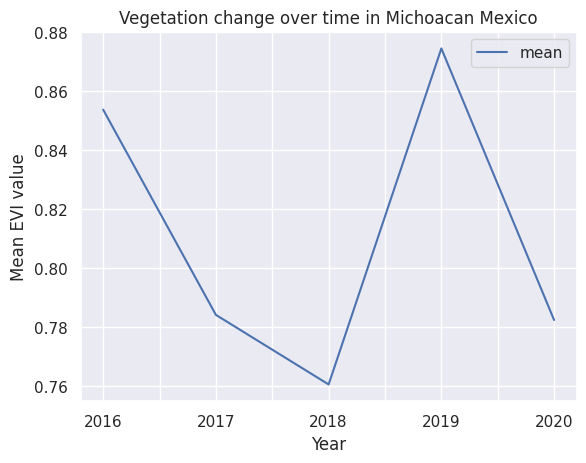

In [274]:
import matplotlib.pyplot as plt

df2 = df_evi.astype(float)
df2.plot(kind='line')
plt.title('Vegetation change over time in Michoacan Mexico')
plt.xlabel('Year')
plt.ylabel('Mean EVI value')
plt.show()

In [275]:
import pandas as pd
nbr_list = {'mean':['0.1691299318',
'0.157017495',
'0.1691674413',
'0.1724102022',
'0.1625675794']}


df_nbr = pd.DataFrame(nbr_list, index=['2016','2017','2018','2019','2020'])
df_nbr

,mean
2016,0.1691299318
2017,0.157017495
2018,0.1691674413
2019,0.1724102022
2020,0.1625675794


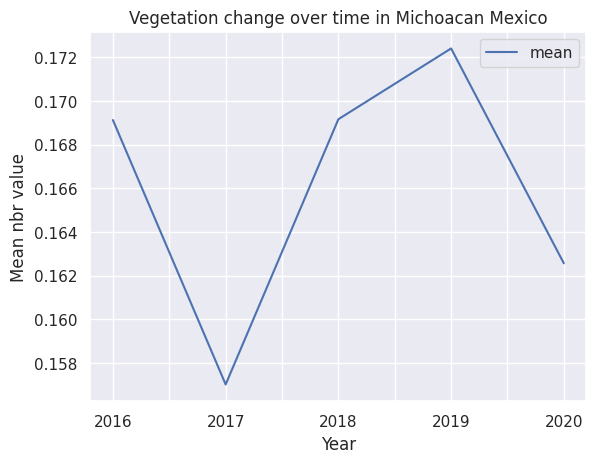

In [276]:
import matplotlib.pyplot as plt

df2 = df_nbr.astype(float)
df2.plot(kind='line')
plt.title('Vegetation change over time in Michoacan Mexico')
plt.xlabel('Year')
plt.ylabel('Mean nbr value')
plt.show()

In [277]:
import pandas as pd
ndvi_list = {'mean':['0.4248446582',
'0.3924871673',
'0.3925375887',
'0.4245744288',
'0.3924871673']}


df_ndvi = pd.DataFrame(ndvi_list, index=['2016','2017','2018','2019','2020'])
df_ndvi

,mean
2016,0.4248446582
2017,0.3924871673
2018,0.3925375887
2019,0.4245744288
2020,0.3924871673


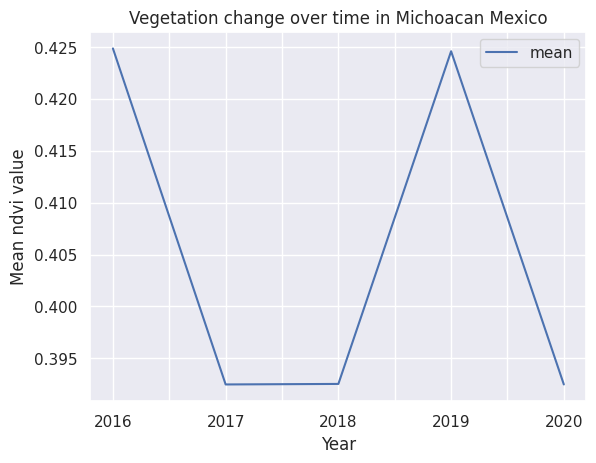

In [278]:
import matplotlib.pyplot as plt

df2 = df_ndvi.astype(float)
df2.plot(kind='line')
plt.title('Vegetation change over time in Michoacan Mexico')
plt.xlabel('Year')
plt.ylabel('Mean ndvi value')
plt.show()

In [279]:
import pandas as pd
savi_list = {'mean':['0.6372040817',
'0.5844604158',
'0.5888709519',
'0.6368554855',
'0.5466045492']}


df_savi = pd.DataFrame(ndvi_list, index=['2016','2017','2018','2019','2020'])
df_savi

,mean
2016,0.4248446582
2017,0.3924871673
2018,0.3925375887
2019,0.4245744288
2020,0.3924871673


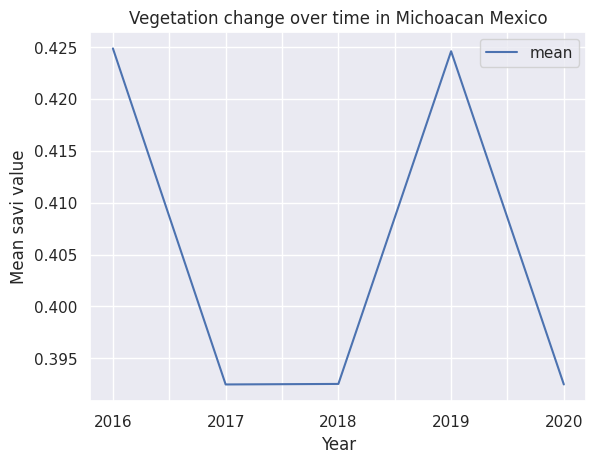

In [283]:
import matplotlib.pyplot as plt

df3 = df_savi.astype(float)
df3.plot(kind='line')
plt.title('Vegetation change over time in Michoacan Mexico')
plt.xlabel('Year')
plt.ylabel('Mean savi value')
plt.show()

In [281]:
import pandas as pd
wdvi_list = {'mean':['0.5471393597',
'0.5185517223',
'0.5185972995',
'0.5490759074',
'0.5220086227']}


df_wdvi = pd.DataFrame(ndvi_list, index=['2016','2017','2018','2019','2020'])
df_wdvi

,mean
2016,0.4248446582
2017,0.3924871673
2018,0.3925375887
2019,0.4245744288
2020,0.3924871673


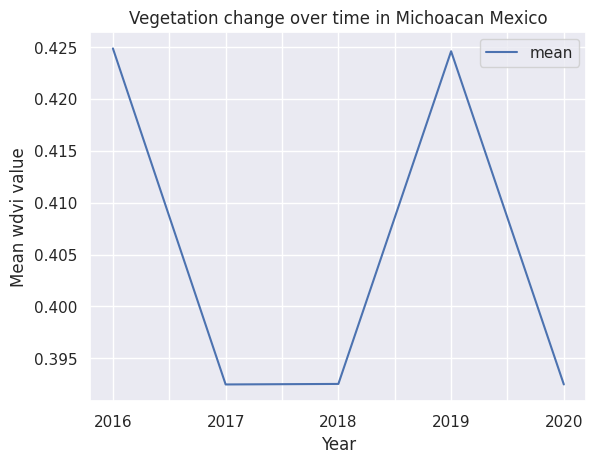

In [282]:
import matplotlib.pyplot as plt

df2 = df_wdvi.astype(float)
df2.plot(kind='line')
plt.title('Vegetation change over time in Michoacan Mexico')
plt.xlabel('Year')
plt.ylabel('Mean wdvi value')
plt.show()